# Python/xarray for GEOS-Chem data analysis

Author: Jiawei Zhuang (jiaweizhuang@g.harvard.edu)

Last updated: 10/16/2017

## Motivation

I have 3 years of experience with IDL and 7 years with MATLAB, but I now use Python for almost all research work because I feel it 10 times more efficient (in terms of human productivity, not just computational performance). 
[Jupyter/IPython Notebook](http://jupyter.org) provides a great scientific research environment and avoids slow x11 forwarding when working with a remote server. Not to mention that Python is free and has become the [NO.1 programming language in 2017](https://spectrum.ieee.org/computing/software/the-2017-top-programming-languages)!

This tutorial focuses on [xarray]( http://xarray.pydata.org/en/stable/), a popular, powerful and elegant Python package for analyzing earth science data. Compared to IDL or MATLAB, Python/xarray allows you to write much less boilerplate codes and focus on real research.

For example, say we want to read a variable *O3* from a NetCDF file *data.nc* and compute its zonal average. The code using xarray would be just 2 lines:
 
```Python
    ds = xr.open_dataset("data.nc") # all information is read into the object ds
    ds['O3'].mean(dim='lon') # the code is self-descriptive
```

The same operation using IDL would be something like (based on [IDL documentation](http://www.harrisgeospatial.com/docs/ncdf_varget.html))

```IDL
    ;Ignore those codes if you have never used IDL before (you are lucky).
    
    fid = NCDF_OPEN('data.nc') ; Open the NetCDF file:
    var_id = NCDF_VARID(fid, 'O3') ; Get the variable ID
    NCDF_VARGET, fid, var_id, data  ; Get the variable data
    NCDF_CLOSE, fid ; close the NetCDF file
    
    ; then write some code to check data dimension, for example
    size(data)
    
    ; OK, say we find that the data is a 4D array of shape [lon,lat,lev,time] 
    ; the quickest way to average over the longitude is
    mean(data, 1) 
    ; The code would be much longer if you write "for" loops
    
    ; What's worse, IDL documentation on this mean() function is wrong!
    ; If you follow http://www.harrisgeospatial.com/docs/MEAN.html ,
    ; you would write
    mean(data, DIMENSION=1) 
    
    ; You want to take average over the first dimension "lon",
    ; But this DIMENSION keyword actually has no effect
    ; You will just get a global mean from the above expression.
    ; This bug is hard to find and could mess up your data analysis.
    
```

I hope this example has convinced you to switch from IDL to Python 😉

## Preparation

Basic knowledge of Python is assumed. For Python beginners, I recommend *Python Data Science Handbook* by *Jake VanderPlas*, which is [free available online](https://jakevdp.github.io/PythonDataScienceHandbook/). Skim through Chapter 1, 2 and 4, then you will be good! (Chapter 3 and 5 are important for general data science but not particularly necessary for working with gridded model data.)

It is crucial to pick up the correct tutorial when learning Python, because Python has a wide range of applications other than just science. For scientific research, you should only read **data science** tutorials. Other famous books such as [Fluent Python](http://shop.oreilly.com/product/0636920032519.do) and [The Hitchhiker's Guide to Python](http://docs.python-guide.org/en/latest/) are great for general software development, but not quite useful for scientific research.

Once you manage to use Python in [Jupyter Notebook](http://jupyter.org), follow this [GCPy page](http://www.danielrothenberg.com/gcpy/getting_started.html#geosciences-python-environment) to set up Python environment for Geosciences. Now you should have everything necessary for working with GEOS-Chem data and most of earth science data in general.


## Reading and exploring NetCDF file

### Opening file

Here we use a GEOS-Chem restart file as an example. You can use your own file or download one at

    ftp://ftp.as.harvard.edu/gcgrid/data/ExtData/NC_RESTARTS/initial_GEOSChem_rst.4x5_benchmark.nc

In [1]:
# those modules are almost always imported when working with model data
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt # general plotting
import cartopy.crs as ccrs # plot on maps, better than the Basemap module

`xr.open_dataset()` reads the entire NetCDF file into this `ds` object. You can view all variables, coordinates, dimensions and metadata by just printing this object.

In [2]:
ds = xr.open_dataset("./initial_GEOSChem_rst.4x5_benchmark.nc")
ds # same as print(ds) in IPython/Jupyter environment

<xarray.Dataset>
Dimensions:      (lat: 46, lev: 72, lon: 72, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2013-07-01
  * lev          (lev) float32 0.9925 0.977456 0.96237 0.947285 0.9322 ...
  * lat          (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 ...
  * lon          (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 ...
Data variables:
    TRC_NO       (time, lev, lat, lon) float64 2.561e-17 2.561e-17 2.561e-17 ...
    TRC_O3       (time, lev, lat, lon) float64 2.615e-08 2.615e-08 2.615e-08 ...
    TRC_PAN      (time, lev, lat, lon) float64 8.709e-12 8.709e-12 8.709e-12 ...
    TRC_CO       (time, lev, lat, lon) float64 6.75e-08 6.75e-08 6.75e-08 ...
    TRC_ALK4     (time, lev, lat, lon) float64 1.753e-10 1.753e-10 1.753e-10 ...
    TRC_ISOP     (time, lev, lat, lon) float64 5.959e-14 5.959e-14 5.959e-14 ...
    TRC_HNO3     (time, lev, lat, lon) float64 5.854e-15 5.854e-15 5.854e-15 ...
    TRC_H2O2     (time, lev, lat, lon) float64 4.73e-11 4

`ds` is an xarray `Dataset`, which is like an in-memory representation of the entire NetCDF file. Just think this data type as a much more powerful version of MATLAB/IDL *structure* type, if you are unfamiliar with Python's [object-oriented programming](https://python.swaroopch.com/oop.html).

In [3]:
type(ds)

xarray.core.dataset.Dataset

### Extracting variable

A `Dataset` typical contains many variables, just like a NetCDF file. To extract a single variable, simply use `ds['varname']`

In [4]:
dr = ds['TRC_O3']
dr

<xarray.DataArray 'TRC_O3' (time: 1, lev: 72, lat: 46, lon: 72)>
[238464 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01
  * lev      (lev) float32 0.9925 0.977456 0.96237 0.947285 0.9322 0.917116 ...
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  O3 tracer
    units:      mol/mol

The returning `dr` is a `DataArray`, containing all information for a single variable, including the numerical data itself, the coodinate information and additional attributes like *long_name* and *units* here.

In [5]:
type(dr)

xarray.core.dataarray.DataArray

`DataArray` (a single variable) and `Dataset` (containing multiple `DataArray`) are the only two data types you need to know in xarray.

### Syntax explanation

Recall that you can select a variable just by its name (`ds['varname']`), not by its underlying ID. This syntax is nothing special -- it just follows the notation of the `dictionary` type, a basic data type in Python for storing key-value pairs.

In [6]:
# make a simple dictionary
# 'var1' is the key, and 1 is the value
my_dict = dict(var1=1, var2=2) 
my_dict 

{'var1': 1, 'var2': 2}

In [7]:
my_dict['var1'] # retrieve the value by the key

1

### Metadata

`DataArray` has some additional attributes to describe the variable. They can be accessed by `.attrs`. 

In [8]:
dr.attrs

OrderedDict([('long_name', 'O3 tracer'), ('units', 'mol/mol')])

It is again a dictionary type (but with fixed order). Again, retrieve the value by the key:

In [9]:
dr.attrs['units']

'mol/mol'

Short cut:

In [10]:
dr.units

'mol/mol'

`DataSet` contains global attributes describing that NetCDF file

In [11]:
ds.attrs['Title']

'COARDS/netCDF file created by BPCH2COARDS (GAMAP v2-17+)'

All available keys are:

In [12]:
ds.attrs.keys()

odict_keys(['Title', 'Conventions', 'Format', 'Model', 'Delta_Lon', 'Delta_Lat', 'NLayers', 'Start_Date', 'Start_Time', 'End_Date', 'End_Time', 'Delta_Time', 'history'])

### Convert to numpy array

If you don't need additional information like coordinates and units, you can always convert a `DataArray` to a pure numpy array by `.values`.

In [13]:
rawdata = dr.values # get pure numpy array

It is a 4D numpy array with the shape (time: 1, lev: 72, lat: 46, lon: 72)

In [14]:
type(rawdata), rawdata.shape

(numpy.ndarray, (1, 72, 46, 72))

### Modifying data

Most of the time you don't need to convert `DataArray` to numpy array, because arithmetic operations and numpy functions can directly work on `DataArray`. Here we multiply the data by $10^9$ and change the unit to ppbv.



In [15]:
dr *= 1e9 # v/v -> ppbv
dr.attrs['units'] = 'ppbv'
dr

<xarray.DataArray 'TRC_O3' (time: 1, lev: 72, lat: 46, lon: 72)>
array([[[[ 26.152373, ...,  26.152373],
         ..., 
         [  6.460082, ...,   6.460082]],

        ..., 
        [[ 59.938827, ...,  59.938827],
         ..., 
         [ 68.322656, ...,  68.322656]]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01
  * lev      (lev) float32 0.9925 0.977456 0.96237 0.947285 0.9322 0.917116 ...
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  O3 tracer
    units:      ppbv

**Now let's look at 3 common use cases. They are meant to be read in order.**

## Case 1: surface field

### Selecting data

Conventionally, you will select data by indexing the pure numerical array `rawdata`, like that:

In [16]:
data_surf = rawdata[0,0,:,:] # get 1st time slice and 1st level
data_surf.shape # only contain lat and lon dimensions

(46, 72)

With the `DataArray` type, you can index the data by dimension names, without thinking about which dimension means *time* and which one means *level*. 

In [17]:
dr_surf = dr.isel(time=0, lev=0)
dr_surf

<xarray.DataArray 'TRC_O3' (lat: 46, lon: 72)>
array([[ 26.152373,  26.152373,  26.152373, ...,  26.152373,  26.152373,
         26.152373],
       [ 26.224114,  26.226319,  26.230103, ...,  26.205269,  26.221985,
         26.20175 ],
       [ 25.707591,  25.481674,  25.132504, ...,  25.927429,  25.662809,
         25.705889],
       ..., 
       [  8.588493,   9.013182,   8.793466, ...,   8.650769,   8.041175,
          8.159272],
       [  6.469575,   6.469804,   6.465895, ...,   6.476197,   6.476856,
          6.473523],
       [  6.460082,   6.460082,   6.460082, ...,   6.460082,   6.460082,
          6.460082]])
Coordinates:
    time     datetime64[ns] 2013-07-01
    lev      float32 0.9925
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  O3 tracer
    units:      ppbv

Verify that both methods give the same result:

In [18]:
np.allclose(data_surf, dr_surf.values)

True

### Convenience method for plotting

A 2D `DataArray` has a convenient `plot()` method.

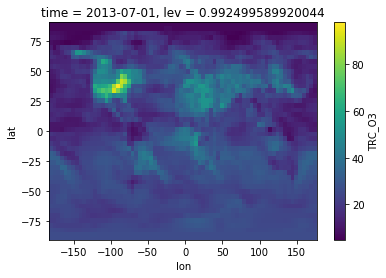

In [19]:
dr_surf.plot()

You can tweak colormap and colorbar range.

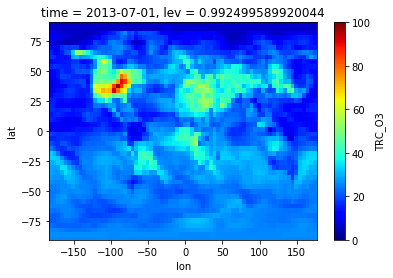

In [20]:
dr_surf.plot(cmap='jet', vmin=0, vmax=100)

See [matplotlib colormap](http://matplotlib.org/examples/color/colormaps_reference.html) for all available color schemes.

### Using gamap's color scheme

We can also use the WhGrYlRd scheme from our good old friend [gamap](http://acmg.seas.harvard.edu/gamap/).

Download this [WhGrYlRd.txt](./WhGrYlRd.txt) file and make a custom colormap (That's a quick solution for now. We'll put this into the GCPy package.)

In [21]:
# get gamap's WhGrYlRd color scheme from file
from matplotlib.colors import ListedColormap
WhGrYlRd_scheme = np.genfromtxt('./WhGrYlRd.txt', delimiter=' ')
WhGrYlRd = ListedColormap(WhGrYlRd_scheme/255.0)

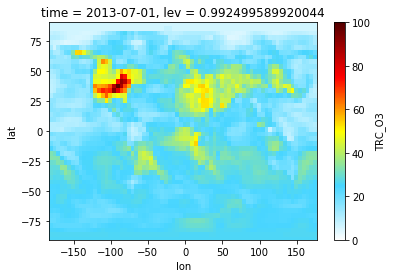

In [22]:
dr_surf.plot(cmap=WhGrYlRd, vmin=0, vmax=100)

## Extending case 1: visualization details

**Note: Feel free to jump to Case 2 if you don't care about detailed plotting for now.** Here we demonstrate how to make publication-quality plots only using basic, low-level plotting functions. We'll provide high-level wrappers in the GCPy package, but knowing how to write things from scratch is also very useful.

### Basic heatmap

To tweak details, we can always fall back to the original matplotlib functions.
The default `plt.pcolormesh()` plots 2D heat maps, but it has no idea about the spherical coordinate.

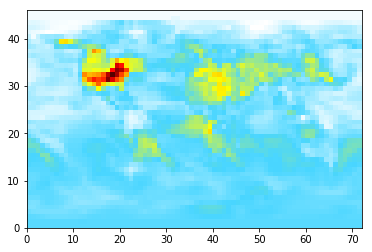

In [23]:
plt.pcolormesh(dr_surf, cmap=WhGrYlRd)

We can get the coordinate values from the `DataArray`, because the original NetCDF file contains the coordinate information.

In [24]:
lat = dr_surf['lat'].values
lon = dr_surf['lon'].values
print('lat:\n', lat)
print('lon:\n', lon)

lat:
 [-89. -86. -82. -78. -74. -70. -66. -62. -58. -54. -50. -46. -42. -38. -34.
 -30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.  14.  18.  22.  26.
  30.  34.  38.  42.  46.  50.  54.  58.  62.  66.  70.  74.  78.  82.  86.
  89.]
lon:
 [-180. -175. -170. -165. -160. -155. -150. -145. -140. -135. -130. -125.
 -120. -115. -110. -105. -100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.
  -60.  -55.  -50.  -45.  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.
    0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175.]


Calling `plt.pcolormesh(X, Y, data)` instead of `plt.pcolormesh(data)` will set correct coordinate values.

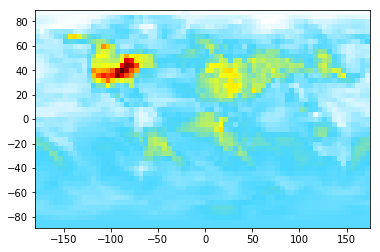

In [25]:
plt.pcolormesh(lon, lat, dr_surf, cmap=WhGrYlRd)

To gain full control on the figure, we can create an `axis` object and call the plotting method on it. 

(This is not too useful here but is particularly useful for multi-panel plots, where each `axis` means one subplot so you can fine-tune each panel. See [here](https://matplotlib.org/gallery/subplots_axes_and_figures/subplot_demo.html#sphx-glr-gallery-subplots-axes-and-figures-subplot-demo-py) for a subplot example.)

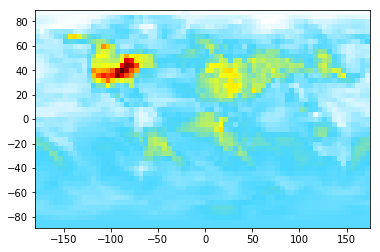

In [26]:
# has the same effect as the previous code cell
ax = plt.axes()
ax.pcolormesh(lon, lat, dr_surf, cmap=WhGrYlRd)

### Geographic maps

To plot on geographic maps, the only change is adding the `projection` keyword to `plt.axes()`

(Recall that `ccrs` is from the [cartopy](http://scitools.org.uk/cartopy/) the package, which is much easier to use than the old [Basemap](https://matplotlib.org/basemap/users/index.html) package).

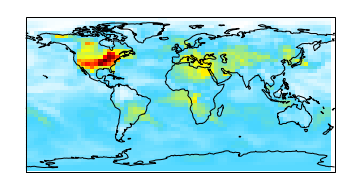

In [27]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.pcolormesh(lon, lat, dr_surf, cmap=WhGrYlRd)

`PlateCarree` is the most commonly used projection but there are tons of projections available. See [cartopy documentation](http://scitools.org.uk/cartopy/docs/v0.13/crs/projections.html#cartopy-projections) for all options.

Let's try the `Robinson` projection. Note that the `transform` keyword still takes `PlateCarree`, for some mathematical reasons.

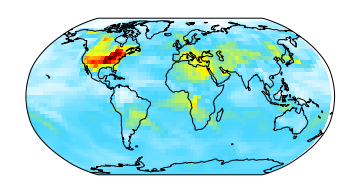

In [28]:
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.pcolormesh(lon, lat, dr_surf, cmap=WhGrYlRd, transform=ccrs.PlateCarree())

### Correcting map boundaries

You might notice a blank stripe on the right edge ($180^\circ E/W$). That's because `pcolormesh(X, Y, data)` expects `X` and `Y` to be cell bounds, not cell centers. Fortunately, creating cell bound coordinates is trivial:

In [29]:
lon_b = np.linspace(-182.5, 177.5, 73)
print(lon_b)

[-182.5 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5
 -132.5 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5
  -82.5  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5
  -32.5  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5
   17.5   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5
   67.5   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5
  117.5  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162.5
  167.5  172.5  177.5]


In [30]:
lat_b = np.linspace(-92, 92, 47)
lat_b[0] = -90 # -92 => -90
lat_b[-1] = 90 #  92 =>  90
print(lat_b)

[-90. -88. -84. -80. -76. -72. -68. -64. -60. -56. -52. -48. -44. -40. -36.
 -32. -28. -24. -20. -16. -12.  -8.  -4.   0.   4.   8.  12.  16.  20.  24.
  28.  32.  36.  40.  44.  48.  52.  56.  60.  64.  68.  72.  76.  80.  84.
  88.  90.]


Now there's no blank stripe in the figure.

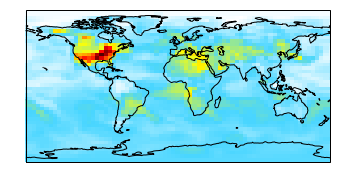

In [31]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon_b, lat_b, dr_surf, cmap=WhGrYlRd)

### Adding details

Add a few more codes to tweak figure size, title, and colorbar.

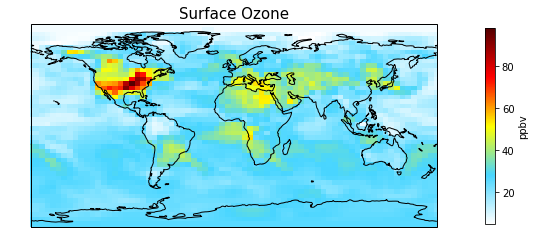

In [32]:
plt.figure(figsize=[10,6]) # make figure bigger

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon_b, lat_b, dr_surf, cmap=WhGrYlRd)

plt.title('Surface Ozone', fontsize=15)
cb = plt.colorbar(shrink=0.6) # use shrink to make colorbar smaller
cb.set_label("ppbv") 

Gridlines and latlon ticks need more codes. But we can create a function and don't have to repeat those those codes for every plot.

In [33]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def add_latlon_ticks(ax):
    '''Add latlon label ticks and gridlines to ax'''
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,30))

Apply the above function to the figure, and finally save the figure to a file.

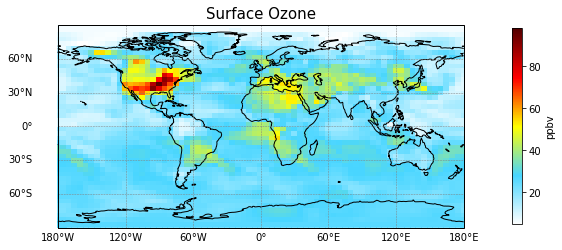

In [34]:
fig = plt.figure(figsize=[10,6])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon_b, lat_b, dr_surf, cmap=WhGrYlRd)
plt.title('Surface Ozone', fontsize=15)

cb = plt.colorbar(shrink=0.6)
cb.set_label("ppbv")

# above codes are exactly the same as the previous example
# only the two lines below are new

add_latlon_ticks(ax) # add ticks and gridlines
fig.savefig('Surface_Ozone.png', dpi=200) # save figure to a file

`dpi=200` leads to a pretty high-quality plot. You can view it [here](./Surface_Ozone.png).

## Case 2: zonal mean

### Dropping unnecessary dimension

Recall that our `DataArray` has 4 dimensions, although the time dimension is redundant.

In [35]:
dr

<xarray.DataArray 'TRC_O3' (time: 1, lev: 72, lat: 46, lon: 72)>
array([[[[ 26.152373, ...,  26.152373],
         ..., 
         [  6.460082, ...,   6.460082]],

        ..., 
        [[ 59.938827, ...,  59.938827],
         ..., 
         [ 68.322656, ...,  68.322656]]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01
  * lev      (lev) float32 0.9925 0.977456 0.96237 0.947285 0.9322 0.917116 ...
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  O3 tracer
    units:      ppbv

Get rid of this redundant dimension for convenience.

In [36]:
dr = dr.isel(time=0)  # equivalent to dr.squeeze() in this case
dr

<xarray.DataArray 'TRC_O3' (lev: 72, lat: 46, lon: 72)>
array([[[ 26.152373,  26.152373, ...,  26.152373,  26.152373],
        [ 26.224114,  26.226319, ...,  26.221985,  26.20175 ],
        ..., 
        [  6.469575,   6.469804, ...,   6.476856,   6.473523],
        [  6.460082,   6.460082, ...,   6.460082,   6.460082]],

       [[ 26.328511,  26.328511, ...,  26.328511,  26.328511],
        [ 26.338292,  26.334288, ...,  26.326118,  26.327644],
        ..., 
        [ 10.846659,  10.846609, ...,  10.846533,  10.846559],
        [ 10.847146,  10.847146, ...,  10.847146,  10.847146]],

       ..., 
       [[ 59.93882 ,  59.93882 , ...,  59.93882 ,  59.93882 ],
        [ 59.93882 ,  59.93882 , ...,  59.93882 ,  59.93882 ],
        ..., 
        [ 68.32267 ,  68.32267 , ...,  68.32267 ,  68.32267 ],
        [ 68.322663,  68.322663, ...,  68.322663,  68.322663]],

       [[ 59.938827,  59.938827, ...,  59.938827,  59.938827],
        [ 59.938813,  59.938813, ...,  59.938813,  59.938813],
 

Of course, you can do the same thing with pure numpy array. Recall that `rawdata` is 4D.

In [37]:
rawdata.shape

(1, 72, 46, 72)

In [38]:
data_sqz = rawdata[0,...] # equivalent to rawdata.squeeze() in this case
data_sqz.shape

(72, 46, 72)

### Averaging

Here comes the example at the beginning! Take zonal average without thinking about dimension order. 

In [39]:
dr_zmean = dr.mean(dim='lon')
dr_zmean 

<xarray.DataArray 'TRC_O3' (lev: 72, lat: 46)>
array([[ 26.152373,  26.194946,  25.725238, ...,  10.479322,   6.539299,
          6.460082],
       [ 26.328511,  26.341357,  26.298183, ...,  13.434381,  10.794238,
         10.847146],
       [ 26.498927,  26.484916,  26.580563, ...,  17.146443,  18.342079,
         18.30816 ],
       ..., 
       [ 59.938841,  59.938838,  60.476615, ...,  68.69855 ,  68.322649,
         68.322649],
       [ 59.93882 ,  59.938823,  60.476616, ...,  68.698553,  68.32267 ,
         68.322663],
       [ 59.938827,  59.938816,  60.476615, ...,  68.698551,  68.322663,
         68.322656]])
Coordinates:
    time     datetime64[ns] 2013-07-01
  * lev      (lev) float32 0.9925 0.977456 0.96237 0.947285 0.9322 0.917116 ...
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...

You can do the same thing with pure numpy array, as long as you know the longitude axis is the last dimension.

In [40]:
data_zmean = data_sqz.mean(axis=2)
data_zmean.shape

(72, 46)

But only having pure numerical data makes me feel unsafe. I often need to double check the `72` above means the number of vertical levels, not the size of longitude dimension.

Check if two approaches give the same result:

In [41]:
np.allclose(dr_zmean.values, data_zmean)

True

### Plotting

`dr_zmean` is a 2D `DataArray`, so it has a convenient plotting method.

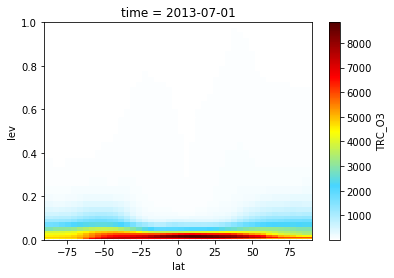

In [42]:
dr_zmean.plot(cmap=WhGrYlRd)

It looks weird, because the `lev` coordinate is the sigma value, not pressure or height.

In [43]:
dr_zmean['lev']

<xarray.DataArray 'lev' (lev: 72)>
array([  9.924996e-01,   9.774562e-01,   9.623704e-01,   9.472854e-01,
         9.322005e-01,   9.171155e-01,   9.020311e-01,   8.869475e-01,
         8.718643e-01,   8.567811e-01,   8.416982e-01,   8.266159e-01,
         8.090211e-01,   7.863999e-01,   7.612653e-01,   7.361340e-01,
         7.110056e-01,   6.858778e-01,   6.544709e-01,   6.167904e-01,
         5.791153e-01,   5.414491e-01,   5.037952e-01,   4.661533e-01,
         4.285283e-01,   3.909265e-01,   3.533493e-01,   3.098539e-01,
         2.635869e-01,   2.237725e-01,   1.900607e-01,   1.615131e-01,
         1.372873e-01,   1.166950e-01,   9.919107e-02,   8.431271e-02,
         7.159988e-02,   6.068223e-02,   5.132635e-02,   4.332603e-02,
         3.649946e-02,   3.067280e-02,   2.569886e-02,   2.146679e-02,
         1.787765e-02,   1.484372e-02,   1.228746e-02,   1.014066e-02,
         8.336023e-03,   6.818051e-03,   5.548341e-03,   4.492209e-03,
         3.618591e-03,   2.899926e-03,   2

We will provide functions to convert it to height or pressure, but for now let's just use level index.

In [44]:
dr_zmean['lev'].values = np.arange(1,73)
dr_zmean['lev'].attrs['units'] = 'unitless'
dr_zmean['lev'].attrs['long_name'] = 'level index'
dr_zmean['lev']

<xarray.DataArray 'lev' (lev: 72)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72])
Coordinates:
    time     datetime64[ns] 2013-07-01
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Attributes:
    long_name:  level index
    units:      unitless
    positive:   up
    axis:       Z

Now the plot looks normal.

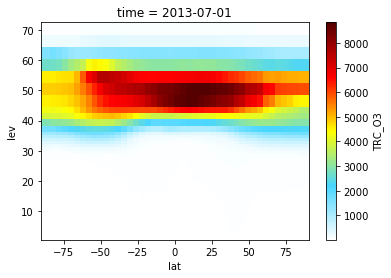

In [45]:
dr_zmean.plot(cmap=WhGrYlRd)

### Slicing

Say we only want to plot the troposphere, we can use a `slice` to select level 1~30.

In [46]:
dr_zmean.isel(lev=slice(0,30))

<xarray.DataArray 'TRC_O3' (lev: 30, lat: 46)>
array([[  26.152373,   26.194946,   25.725238, ...,   10.479322,    6.539299,
           6.460082],
       [  26.328511,   26.341357,   26.298183, ...,   13.434381,   10.794238,
          10.847146],
       [  26.498927,   26.484916,   26.580563, ...,   17.146443,   18.342079,
          18.30816 ],
       ..., 
       [  53.418344,   53.418347,   45.959175, ...,   80.124412,   84.74668 ,
          84.746681],
       [  71.646951,   71.646957,   58.809819, ...,  102.935995,  110.957415,
         110.957423],
       [ 104.243057,  104.243062,   81.957629, ...,  176.496959,  179.441246,
         179.441244]])
Coordinates:
    time     datetime64[ns] 2013-07-01
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...

The equivalent way in numpy would be:

In [47]:
data_zmean[0:30,:]

array([[  26.15237271,   26.19494634,   25.72523762, ...,   10.47932228,
           6.53929865,    6.46008225],
       [  26.32851093,   26.34135744,   26.29818292, ...,   13.43438139,
          10.79423836,   10.84714629],
       [  26.4989275 ,   26.48491587,   26.58056279, ...,   17.14644329,
          18.34207919,   18.30816032],
       ..., 
       [  53.41834353,   53.41834703,   45.95917533, ...,   80.12441219,
          84.74668009,   84.74668078],
       [  71.64695148,   71.64695711,   58.80981943, ...,  102.93599454,
         110.95741481,  110.95742281],
       [ 104.24305685,  104.24306179,   81.95762888, ...,  176.49695927,
         179.44124566,  179.44124409]])

Only plot the tropospheric region:

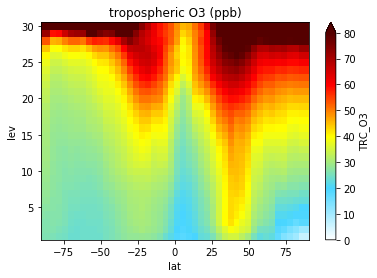

In [48]:
dr_zmean.isel(lev=slice(0,30)).plot(cmap=WhGrYlRd, vmax=80, vmin=0)
plt.title('tropospheric O3 (ppb)') # overwrite the default title

## Case 3: vertical profile

### Selecting data

Say we want to plot the O3 profile at a specific location. Let's see what locations are available.

In [49]:
print('lat:\n', dr['lat'].values)
print('lon:\n', dr['lon'].values)

lat:
 [-89. -86. -82. -78. -74. -70. -66. -62. -58. -54. -50. -46. -42. -38. -34.
 -30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.  14.  18.  22.  26.
  30.  34.  38.  42.  46.  50.  54.  58.  62.  66.  70.  74.  78.  82.  86.
  89.]
lon:
 [-180. -175. -170. -165. -160. -155. -150. -145. -140. -135. -130. -125.
 -120. -115. -110. -105. -100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.
  -60.  -55.  -50.  -45.  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.
    0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175.]


Say we want to select $(30^{\circ}N, 60^{\circ}E)$. Hey, don't count which element in `lat` array is 30! `sel` (instead of `isel`) can select data by coordinate **values**, not by coordinate **index**. This feature allows you to use almost the same code for data at different resolutions.

In [50]:
profile = dr.sel(lat=30, lon=60)
profile

<xarray.DataArray 'TRC_O3' (lev: 72)>
array([   40.683279,    50.502422,    58.76155 ,    59.553575,    59.688794,
          59.776063,    59.863531,    59.921533,    59.98514 ,    60.082513,
          60.335651,    61.095989,    62.673543,    65.194925,    67.979464,
          70.64056 ,    73.474794,    74.231899,    74.188087,    75.221195,
          77.541642,    80.683797,    83.345057,    82.974218,    80.626258,
          75.736345,    73.050543,    72.00984 ,    78.042632,    82.909999,
          86.870436,    91.910749,    97.782276,   102.39502 ,   129.772232,
         225.23146 ,   950.023207,   950.023036,  2735.300086,  2735.299631,
        4467.107829,  4467.108738,  6410.347396,  6410.347851,  8152.221199,
        8152.217561,  8152.21847 ,  8152.222108,  8664.22306 ,  8664.223969,
        8664.226698,  8664.225788,  6528.357062,  6528.355243,  6528.353879,
        6528.356153,  3128.377784,  3128.377784,  3128.377784,  3128.37733 ,
        1485.034545,  1485.03409 ,  14

### Plotting

`profile` is a 1D `DataArray` and it also has a convenience method for plotting.

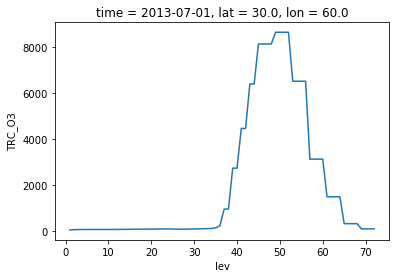

In [51]:
profile.plot()

This is particularly useful for time-series, but for profile we want `lev` to be the y-axis. We can always fall back to basic matplotlib functions.

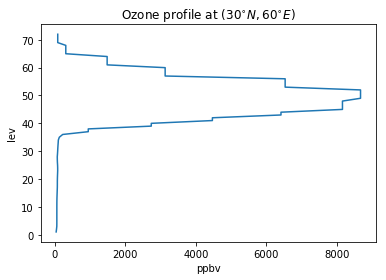

In [52]:
plt.plot(profile, profile['lev'])
plt.ylabel('lev');plt.xlabel('ppbv')
plt.title('Ozone profile at $(30^{\circ}N, 60^{\circ}E)$')

## Writing NetCDF file

During the previous 3 cases, we've made several changes to our `DataArray` object, including

- scale its value by $10^{9}$
- change its attribute 'unit' from 'mol/mol' to 'ppbv'
- drop the time dimension
- change its vertical coordinate values to integers
- change the vertical coordinate unit to 'unitless'

In [53]:
dr # check its content

<xarray.DataArray 'TRC_O3' (lev: 72, lat: 46, lon: 72)>
array([[[ 26.152373,  26.152373, ...,  26.152373,  26.152373],
        [ 26.224114,  26.226319, ...,  26.221985,  26.20175 ],
        ..., 
        [  6.469575,   6.469804, ...,   6.476856,   6.473523],
        [  6.460082,   6.460082, ...,   6.460082,   6.460082]],

       [[ 26.328511,  26.328511, ...,  26.328511,  26.328511],
        [ 26.338292,  26.334288, ...,  26.326118,  26.327644],
        ..., 
        [ 10.846659,  10.846609, ...,  10.846533,  10.846559],
        [ 10.847146,  10.847146, ...,  10.847146,  10.847146]],

       ..., 
       [[ 59.93882 ,  59.93882 , ...,  59.93882 ,  59.93882 ],
        [ 59.93882 ,  59.93882 , ...,  59.93882 ,  59.93882 ],
        ..., 
        [ 68.32267 ,  68.32267 , ...,  68.32267 ,  68.32267 ],
        [ 68.322663,  68.322663, ...,  68.322663,  68.322663]],

       [[ 59.938827,  59.938827, ...,  59.938827,  59.938827],
        [ 59.938813,  59.938813, ...,  59.938813,  59.938813],
 

We can save this modified `DataArray` to a file by just one line of code. This simplicity is just amazing, compare to the terribly complicated procedure [in IDL](http://www.harrisgeospatial.com/docs/ncdf_varput.html).

In [54]:
dr.to_netcdf('O3_restart.nc')

Use `ncdump` in the Linux shell to check its content:

    $ncdump -h O3_restart.nc
    
    netcdf O3_restart {
    dimensions:
        lev = 72 ;
        lat = 46 ;
        lon = 72 ;
    variables:
        float time ;
            time:_FillValue = NaNf ;
            time:long_name = "Time" ;
            time:axis = "T" ;
            time:delta_t = "0000-00-00 00:00:00" ;
            time:units = "hours since 1985-01-01" ;
            time:calendar = "gregorian" ;
        float lev(lev) ;
            lev:_FillValue = NaNf ;
            lev:long_name = "level index" ;
            lev:units = "unitless" ;
            lev:positive = "up" ;
            lev:axis = "Z" ;
        float lat(lat) ;
            lat:_FillValue = NaNf ;
            lat:long_name = "Latitude" ;
            lat:units = "degrees_north" ;
            lat:axis = "Y" ;
        float lon(lon) ;
            lon:_FillValue = NaNf ;
            lon:long_name = "Longitude" ;
            lon:units = "degrees_east" ;
            lon:axis = "X" ;
        float TRC_O3(lev, lat, lon) ;
            TRC_O3:_FillValue = 1.e+30f ;
            TRC_O3:long_name = "O3 tracer" ;
            TRC_O3:units = "ppbv" ;
            TRC_O3:add_offset = 0.f ;
            TRC_O3:scale_factor = 1.f ;

    // global attributes:
            :coordinates = "time" ;
    }

We can see that the file has pretty complete information -- dimensions, coordinates, units, everything looks fine.

Finally, open this new file to check everything is correct:

In [55]:
xr.open_dataarray('O3_restart.nc')

<xarray.DataArray 'TRC_O3' (lev: 72, lat: 46, lon: 72)>
[238464 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 2013-07-01
  * lev      (lev) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * lat      (lat) float32 -89.0 -86.0 -82.0 -78.0 -74.0 -70.0 -66.0 -62.0 ...
  * lon      (lon) float32 -180.0 -175.0 -170.0 -165.0 -160.0 -155.0 -150.0 ...
Attributes:
    long_name:  O3 tracer
    units:      ppbv

## Further reading

Check out [xarray documentation]( http://xarray.pydata.org/en/stable/), especially the [examples](http://xarray.pydata.org/en/stable/examples.html)!